# Mengimport Library

In [3]:
import os
import shutil
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
import pandas as pd
import gdown
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
!pip install tensorflow
!pip install tensorflowjs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
!pip install keras-tuner
from kerastuner.tuners import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load Data

In [4]:
drive.mount('/content/drive')

file_id = '1waFro-FfyyLObJVm8bxdiEKwSWGn3oJi'
output_filename = 'hasil_preprocessing.csv'

try:
    gdown.download(id=file_id, output=output_filename, quiet=False)
    print(f"File {output_filename} berhasil diunduh!")

    df = pd.read_csv(output_filename)
    print(df.head())

except Exception as e:
    print(f"Gagal mengunduh atau membaca file: {e}")


Mounted at /content/drive


Downloading...
From: https://drive.google.com/uc?id=1waFro-FfyyLObJVm8bxdiEKwSWGn3oJi
To: /content/hasil_preprocessing.csv
100%|██████████| 4.92M/4.92M [00:00<00:00, 24.4MB/s]

File hasil_preprocessing.csv berhasil diunduh!
                                               Tweet     Label  \
0  Kecemasan saya memberitahu saya untuk tidak ju...  Negative   
1  Khawatir saya menderita kanker ovarium. Semaki...  Negative   
2  Untuk Penderita HA yang memiliki kecemasan yan...  Negative   
3  Eye floaters karena stres? Halo, Saya baru-bar...  Negative   
4  Ada rasa cemas berlebihan saat ini, .Dan, masi...  Negative   

                                          text_akhir  
0  cemas memberitahu jujurrentan kencan cemas mem...  
1  khawatir derita kanker ovarium media sosial de...  
2  derita tertawa milik cemas beda takut beda ter...  
3  eye floaters stres halo barubaru periksa mata ...  
4                                         rasa cemas  


In [5]:
# Drop baris yang kosong di kolom 'text_akhir'
df = df.dropna(subset=['text_akhir'])
df = df.drop_duplicates(subset=['text_akhir'])

# Tahap Vectorizer menggunakan TFIDF

In [6]:
# vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['text_akhir'])

# Pastikan label di-encode
le = LabelEncoder()
y = le.fit_transform(df['Label'])  # df['label'] berisi string seperti "Positive", "Negative", dll


# Modeling

## Logistic Regression Model

In [7]:
# Membagi data training
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Modeling (Logistic Regression)
logistic_model = LogisticRegression(class_weight='balanced')
logistic_model.fit(X_train, y_train)

# Report
y_pred = logistic_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1142
           1       0.76      0.86      0.81       882

    accuracy                           0.82      2024
   macro avg       0.82      0.83      0.82      2024
weighted avg       0.83      0.82      0.82      2024



## Testing

In [8]:
def predict_text_lr(text, vectorizer, model, label_encoder):
    vectorized = vectorizer.transform([text])
    prediction = model.predict(vectorized)
    confidence = model.predict_proba(vectorized).max()
    label = label_encoder.inverse_transform(prediction)[0]
    return label, confidence

text_input = "Aku merasa sangat bahagia dan penuh energi setiap hari. Pekerjaan berjalan lancar, dan aku punya waktu cukup untuk melakukan hal-hal yang aku suka, seperti olahraga, membaca, dan berkumpul dengan teman-teman. Aku bisa mengatur waktu dengan baik, jadi tidak merasa terburu-buru atau terbebani. Tidurku nyenyak dan bangun pagi dengan semangat baru. Ketika menghadapi masalah, aku tenang dan yakin bisa menyelesaikannya. Aku merasa bersyukur atas dukungan orang-orang terdekat dan selalu melihat sisi positif dari setiap situasi."

label, confidence = predict_text_lr(text_input, vectorizer, logistic_model, le)
print("Hasil Prediksi:", label)
print("Kepercayaan Model:", round(confidence * 100, 2), "%")


Hasil Prediksi: Positive
Kepercayaan Model: 59.59 %


## LSTM Model

In [9]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_akhir'])

X_seq = tokenizer.texts_to_sequences(df['text_akhir'])
X_pad = pad_sequences(X_seq, maxlen=30)


In [10]:
le = LabelEncoder()
y = le.fit_transform(df['Label'])
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=42)


In [11]:
le = LabelEncoder()
y_encoded = le.fit_transform(df['Label'])

# Define num_classes before building the model
num_classes = len(le.classes_)

# Hitung class weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(zip(np.unique(y_encoded), class_weights))

# modeling
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=30),  # Changed input_shape to input_length
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use num_classes instead of hardcoded 2
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85):
      print("\nAkurasi telah mencapai >85%!")
      self.model.stop_training = True
callbacks = myCallback()

# train
model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[callbacks]
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 52s 124ms/step - accuracy: 0.6901 - loss: 0.5490 - val_accuracy: 0.8118 - val_loss: 0.4086
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8739 - loss: 0.3015
Akurasi telah mencapai >85%!
253/253 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.8738 - loss: 0.3015 - val_accuracy: 0.8325 - val_loss: 0.3773


## Visualisasi

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1155
           1       0.84      0.75      0.79       869

    accuracy                           0.83      2024
   macro avg       0.83      0.82      0.83      2024
weighted avg       0.83      0.83      0.83      2024



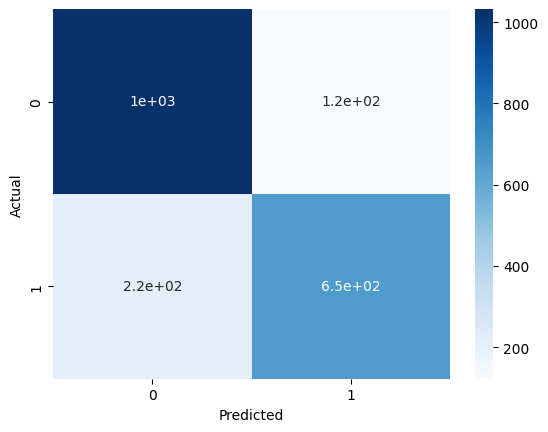

In [12]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Testing Model

In [13]:
def predict_text(text, tokenizer, model, label_encoder, maxlen=100):
    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=maxlen)

    # Prediksi
    prediction = model.predict(padded)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    confidence = np.max(prediction)

    return predicted_label[0], confidence

text_input = "Aku merasa sangat bahagia dan penuh energi setiap hari. Pekerjaan berjalan lancar, dan aku punya waktu cukup untuk melakukan hal-hal yang aku suka, seperti olahraga, membaca, dan berkumpul dengan teman-teman. Aku bisa mengatur waktu dengan baik, jadi tidak merasa terburu-buru atau terbebani. Tidurku nyenyak dan bangun pagi dengan semangat baru. Ketika menghadapi masalah, aku tenang dan yakin bisa menyelesaikannya. Aku merasa bersyukur atas dukungan orang-orang terdekat dan selalu melihat sisi positif dari setiap situasi."
# Mengubah label_encoder menjadi le
label, confidence = predict_text(text_input, tokenizer, model, le)

print("Hasil Prediksi:", label)
print("Kepercayaan Model:", round(confidence * 100, 2), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Hasil Prediksi: Positive
Kepercayaan Model: 86.69 %


In [14]:
# List teks yang ingin diuji dengan bahasa gaul
texts_gaul = [
    "Gue lagi happy banget akhir-akhir ini, berasa hidup tuh ringan dan seru aja gitu.",
    "Gue udah mentok banget sama kerjaan, tiap hari nambah mulu sampe kepala mumet.",
    "Hari ini biasa aja sih, gak rame gak sepi, yaa flat aja gitu.",
    "Tadi malam tidur nyenyak parah, bangun langsung fresh dan semangat banget.",
    "Akhir-akhir ini gue gampang panik, susah fokus, kepala rasanya penuh terus."
]

# Looping prediksi
for i, text in enumerate(texts_gaul):
    label, confidence = predict_text(text, tokenizer, model, le)
    print(f"Teks {i+1}: {text[:50]}...")
    print(f"→ Prediksi: {label} | Confidence: {confidence:.2%}")
    print("-" * 60)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Teks 1: Gue lagi happy banget akhir-akhir ini, berasa hidu...
→ Prediksi: Positive | Confidence: 96.07%
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Teks 2: Gue udah mentok banget sama kerjaan, tiap hari nam...
→ Prediksi: Positive | Confidence: 80.72%
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Teks 3: Hari ini biasa aja sih, gak rame gak sepi, yaa fla...
→ Prediksi: Positive | Confidence: 86.82%
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Teks 4: Tadi malam tidur nyenyak parah, bangun langsung fr...
→ Prediksi: Positive | Confidence: 85.17%
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Teks 5: Akhir-akhir ini gue gampang panik, susah fokus, ke...
→ Prediksi: Positive | Confidence: 58.26%
---------------------------------------------

dari percobaan diatas dapat disimpulkan model masih belum bisa menerima atau menangkap teks dengan bahasa gaul.

# convert model to Tensorflow js

In [20]:
# Simpan model dengan format SavedModel
model.save('model_saya.h5')  # Akan menghasilkan file model_saya.h5

# Konversi ke TFJS
!tensorflowjs_converter --input_format=keras model_saya.h5 tfjs_model

2025-05-23 14:43:30.312194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748011410.335976    2286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748011410.342999    2286 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [21]:
# Pindahkan folder tfjs_model ke dalam Google Drive

# Check if the destination directory exists and remove it if it does
destination_dir = "/content/drive/MyDrive/Colab Notebooks/project capstone notebook/tfjs_model"
if os.path.exists(destination_dir):
    print(f"Removing existing directory: {destination_dir}")
    shutil.rmtree(destination_dir)

# Now, copy the new directory
shutil.copytree("/content/tfjs_model", destination_dir)
print(f"Successfully copied tfjs_model to {destination_dir}")

Removing existing directory: /content/drive/MyDrive/Colab Notebooks/project capstone notebook/tfjs_model
Successfully copied tfjs_model to /content/drive/MyDrive/Colab Notebooks/project capstone notebook/tfjs_model


In [22]:
import json

with open("/content/drive/MyDrive/Colab Notebooks/project capstone notebook/tokenizer.json", "w") as f:
    json.dump(tokenizer.word_index, f)